In [1]:
import json
import time
import datetime
import requests
import pybybit
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge

from config import get_config
from logic_funcs import feature_engineering, get_model, logic
from data_get_funcs import get_btc_ohlcv, get_depth, get_data
from bybit_funcs import get_position, market_order
from utils import discord_Notify



In [2]:
df = get_data()
df, feats = feature_engineering(df)
model = get_model(df, feats)
p = model.predict(df[feats].values[-1].reshape(1, -1))
print(p)

[18.40553538]


In [7]:
from bitmex import bitmex
def get_eth():
    config = get_config()
    bitmex_client = bitmex(test=False, api_key=config["bitmex_key"], api_secret=config["bitmex_secret"])
    symbol = "ETH"
    t = datetime.datetime.strptime("2018-8", "%Y-%M") ## これより過去は取れない
    df_eth = pd.DataFrame(bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize="1d", count=1000, reverse=False, startTime = t).result()[0])
    df_eth = df_eth[["timestamp", "open", "high", "low", "close", "trades", "volume", "vwap"]]
    df_eth = df_eth.add_suffix("_eth")
    df_eth["time"] = df_eth["timestamp_eth"].apply(lambda a : datetime.datetime.strptime(str(a).split("+")[0], "%Y-%m-%d  %H:%M:%S"))
    return df_eth

In [8]:

def get_data():
    data = get_btc_ohlcv()
    dep = get_depth()
    df = data.merge(dep)
    eth = get_eth()
    df = df.merge(eth, on = "time")
    feats = ["time", "close", "open", "high", "low", "volume",
    "asks5", "bids5", "asks10", "bids10", "asks20", "bids20", "asks30", "bids30", "asks50", "bids50", "asks90", "bids90"]
    feats += ["open_eth", "high_eth", "low_eth", "close_eth", "trades_eth", "volume_eth", "vwap_eth"]
    df = df[feats]
    return df


In [41]:
df = get_data()

/opt/conda/lib/python3.6/site-packages/swagger_spec_validator/validator20.py:53: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  ref_dict['$ref'], '/'.join(path),


In [42]:
pd.to_pickle(df, "data.pkl")

In [261]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

def evaluate(df, feats):
    for f in feats:
        df[f] = df[f].astype(np.float32)

    df = df[feats + ["time", "target", "baseline"]][df[feats].isna().sum(axis = 1) == 0]
#     t = "2020-01-01"
    t = "2019-03-01"
#     t = "2019-09-01"
#     t = "2019-06-01"
    train = df[df["time"] < datetime.datetime.strptime(t, '%Y-%m-%d')].reset_index(drop = True)
    test = df[df["time"] >= datetime.datetime.strptime(t, '%Y-%m-%d')].reset_index(drop = True)
    train[feats] = train[feats].fillna(train[feats].mean())
    print(train.shape, test.shape)
    
    th = 500
    model = Ridge(1000)
    model.fit(train[feats], np.clip(train["target"], -th, th))
    fi = pd.DataFrame()
    fi["name"] = feats
    fi["coef"] = model.coef_
    fi["coef_abs"] = np.abs(fi["coef"])
    fi = fi.sort_values(by = "coef_abs", ascending = False)
    plt.figure(figsize = (8, 14))
    sns.barplot(data = fi, x = "coef", y = "name")
    plt.show()
    
    p = model.predict(test[feats])
    corr = np.corrcoef(test["target"], p)[0,1]
    
    for df in [train, test]:
        p = model.predict(df[feats])
        df["rev"] = df["target"]
        plt.plot(df["rev"].cumsum(), label = "cumsum")

        df["rev"] = df["target"]
        df.loc[df["baseline"] == False, "rev"] *= -1
        plt.plot(df["rev"].cumsum(), label = "2day before")

        df["rev"] = df["target"]
        th = 0
        df.loc[p < -th, "rev"] *= -1
        df.loc[np.abs(p) < th, "rev"] *= 0
        plt.plot(df["rev"].cumsum(), label = "proposed")
        plt.legend()
        plt.show()
        
    print(np.sum(test["rev"]))
    return corr

In [262]:

def feature_engineering(df):
#     df = pd.read_pickle("data.pkl")
    df["target"] = df["close"].diff().shift(-1)
    df["baseline"] = (df["close"] - df["open"]).shift(1) > 0
    
    df["feature_c-o"] = (df["close"] - df["open"])
    df["feature_h-c"] = (df["high"] - df["close"])
    df["feature_l-c"] = (df["low"] - df["close"])
    df["feature_h-o"] = (df["high"] - df["open"])
    df["feature_l-o"] = (df["low"] - df["open"])
    df["feature_h-l"] = (df["high"] - df["low"])

    feats = ["feature_c-o", "feature_h-c", "feature_l-c", "feature_h-o", "feature_l-o", "feature_h-l"]
    for f in feats:
        for rol in [7, 14]:
            df[f"{f}_vs_roll{rol}"] = df[f] > (df[f].rolling(rol).agg("mean"))
    for shift in range(1, 3):
        for f in feats:
            df[f + f"_shift_{shift}"] = df[f].shift(shift)
            
    df["feature_c-o_eth"] = (df["close_eth"] - df["open_eth"])
    df["feature_h-c_eth"] = (df["high_eth"] - df["close_eth"])
    df["feature_l-c_eth"] = (df["low_eth"] - df["close_eth"])
    df["feature_h-o_eth"] = (df["high_eth"] - df["open_eth"])
    df["feature_l-o_eth"] = (df["low_eth"] - df["open_eth"])
    df["feature_h-l_eth"] = (df["high_eth"] - df["low_eth"])

    feats = ["feature_c-o_eth", "feature_h-c_eth", "feature_l-c_eth", "feature_h-o_eth", "feature_l-o_eth", "feature_h-l_eth"]
    for f in feats:
        for rol in [7, 14]:
            df[f"{f}_vs_roll{rol}"] = df[f] > (df[f].rolling(rol).agg("mean"))
    for shift in range(1, 3):
        for f in feats:
            df[f + f"_shift_{shift}"] = df[f].shift(shift)
            
            
    for dep in [20, 30, 50, 90]:
        df[f"features_bid-ask{dep}"] = df[f"bids{dep}"] - df[f"asks{dep}"]
        for rol in [7, 14]:
            df[f"features_bid-ask{dep}_vs_roll{rol}"] = df[f"features_bid-ask{dep}"] > (df[f"features_bid-ask{dep}"].rolling(rol).agg("mean"))
        df[f"features_bid-ask{dep}"] = df[f"features_bid-ask{dep}"] > 0
    dep_cols = [c for c in df.columns if "ask" in c or "bid" in c and "feature" in c]
    for shift in range(1, 2):
        for c in dep_cols:
            df[c + f"_shift_{shift}"] = df[c].shift(shift)

    feats = [c for c in df.columns if "feature" in c]# + dep_shifts_cols
    
    for k in range(7):
        df[f"feature_dow_{k}"] = df.index % 7 == k
    
    for f in feats:
        df[f] = df[f] > 0
#     print(len(feats))
#     evaluate(df, feats)
    
    return df, feats

91
(211, 94) (532, 94)


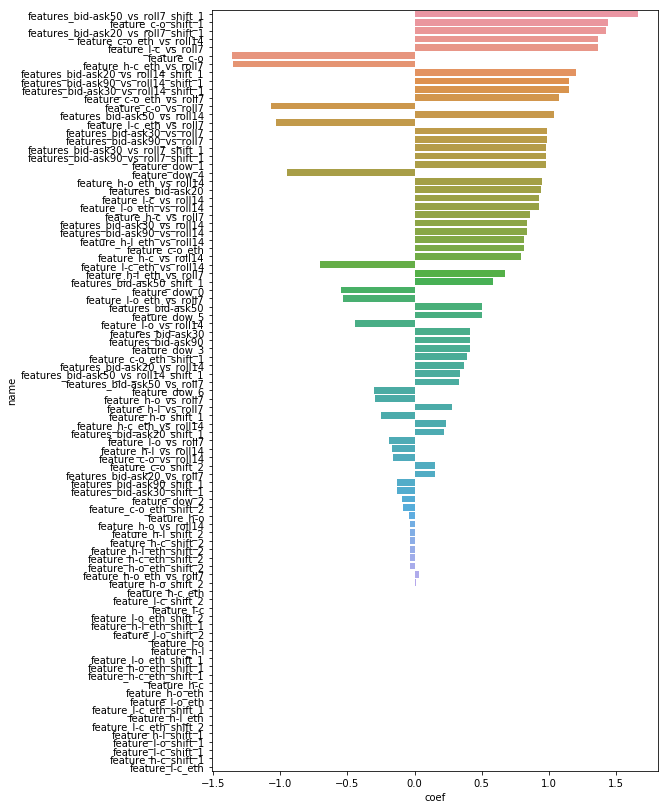

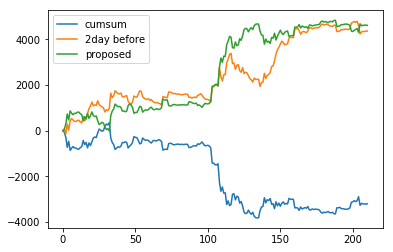

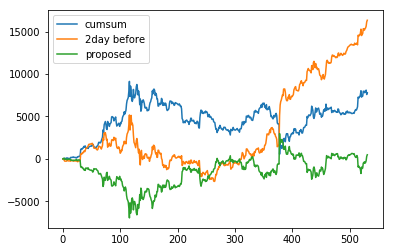

482.5


0.14943263152277733

In [263]:
import seaborn as sns
df = pd.read_pickle("data.pkl")
df, feats = feature_engineering(df)
df = df[df.isna().sum(axis = 1) == 0].reset_index(drop = True)

feats = [c for c in df.columns if "feature" in c]# + dep_shifts_cols
print(len(feats))
evaluate(df, feats)

In [256]:

for f in feats:
    df[f] = df[f].astype(np.float32)

df = df[feats + ["time", "target", "baseline"]][df[feats].isna().sum(axis = 1) == 0]
# t = "2020-01-01"
t = "2019-03-01"
# t = "2019-09-01"
# t = "2019-06-01"
train = df[df["time"] < datetime.datetime.strptime(t, '%Y-%m-%d')].reset_index(drop = True)
test = df[df["time"] >= datetime.datetime.strptime(t, '%Y-%m-%d')].reset_index(drop = True)
train[feats] = train[feats].fillna(train[feats].mean())

In [280]:
from scipy import optimize
from functools import partial
def eval_func(w, train, feats, lam = 0):
    x = train[feats].values
    target = train["target"].values.copy()
    p = np.dot(x, w[:-1]) + w[-1]
    target[p<=0] *= -1
    score = np.sum(target)
    reg = np.sum(np.abs(w)) * lam
    score = score - reg
    return -score

In [258]:
func = partial(eval_func, train = train, feats = feats)
w = np.zeros(len(feats) + 1)
w_opt = optimize.fmin(func, w)
print(np.array(feats)[w_opt[:-1] > 0])
eval_func(w_opt, test, feats)

Optimization terminated successfully.
         Current function value: -8582.414332
         Iterations: 3706
         Function evaluations: 5067
['feature_l-c' 'feature_l-o' 'feature_c-o_vs_roll14'
 'feature_h-c_vs_roll7' 'feature_h-c_vs_roll14' 'feature_l-c_vs_roll7'
 'feature_l-c_vs_roll14' 'feature_h-o_vs_roll7' 'feature_h-o_vs_roll14'
 'feature_l-o_vs_roll7' 'feature_h-l_vs_roll7' 'feature_h-l_vs_roll14'
 'feature_c-o_shift_1' 'feature_l-c_shift_1' 'feature_l-o_shift_1'
 'feature_c-o_shift_2' 'feature_l-c_shift_2' 'feature_l-o_shift_2'
 'feature_c-o_eth' 'feature_l-c_eth' 'feature_l-o_eth'
 'feature_c-o_eth_vs_roll7' 'feature_c-o_eth_vs_roll14'
 'feature_h-c_eth_vs_roll14' 'feature_l-c_eth_vs_roll14'
 'feature_h-o_eth_vs_roll7' 'feature_h-o_eth_vs_roll14'
 'feature_l-o_eth_vs_roll14' 'feature_h-l_eth_vs_roll7'
 'feature_h-l_eth_vs_roll14' 'feature_c-o_eth_shift_1'
 'feature_l-c_eth_shift_1' 'feature_l-o_eth_shift_1'
 'feature_c-o_eth_shift_2' 'feature_l-c_eth_shift_2'
 'feature_l-

-495.41433220514625

In [264]:
w = [1 if c == "feature_c-o_shift_1" else 0 for c in feats] + [0]
w = np.array(w)
eval_func(w, test, feats)

-16231.5

In [312]:
feats = [c for c in df.columns if "feature" in c]# + dep_shifts_cols

th = 500
model = Ridge(1000)
model.fit(train[feats], np.clip(train["target"], -th, th))
p = model.predict(test[feats])
target = test["target"].values.copy()
target[p<=0] *= -1
score = np.sum(target)
-score

-482.5

In [313]:
feats = ["feature_dow_1", "features_bid-ask50_vs_roll7_shift_1", "feature_c-o_shift_1", "feature_h-o_eth_vs_roll14"]

In [314]:
th = 500
model = Ridge(1000)
model.fit(train[feats], np.clip(train["target"], -th, th))
p = model.predict(test[feats])
target = test["target"].values.copy()
target[p<=0] *= -1
score = np.sum(target)
-score

7768.5

In [302]:
scores = []
for k in range(len(feats)):
    w = np.zeros(len(feats) + 1)
    w[k] = 1
    score = eval_func(w, train, feats)
    scores.append(-score)

In [303]:
d = pd.DataFrame()
d["name"] = feats
d["score"] = scores

In [305]:
d.sort_values(by = "score")

,name,score
21,feature_h-o_shift_1,-3669.5
40,feature_l-c_eth_vs_roll7,-3640.5
0,feature_c-o,-3385.5
3,feature_h-o,-3250.5
25,feature_h-c_shift_2,-3231.5
59,feature_h-l_eth_shift_2,-3231.5
57,feature_h-o_eth_shift_2,-3231.5
29,feature_h-l_shift_2,-3231.5
55,feature_h-c_eth_shift_2,-3231.5
23,feature_h-l_shift_1,-3203.5


('feature_dow_1',
 'ask50_vs_roll7_shift_1',
 'feature_c-o_shift_1',
 'feature_h-o_eth_vs_roll14')